In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkapteijns/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/bkapteijns/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bkapteijns/nltk_data...


True

In [3]:
df = pd.read_csv("Tweets.csv")
df[["airline_sentiment","text"]].head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


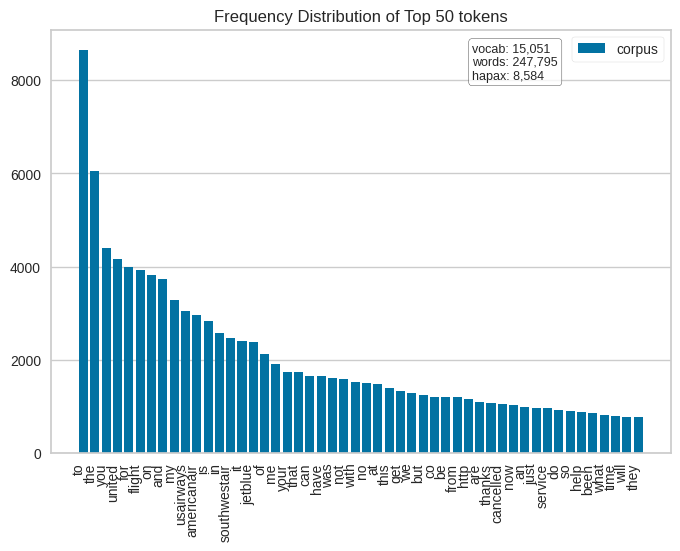

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [4]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [5]:
text = df["text"]
labels = df["airline_sentiment"]

print(text.shape, labels.shape)

(14640,) (14640,)


In [6]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

text.shape

(14640,)

In [24]:
# import pickle
# with open("text.pkl", "wb") as f:
#   pickle.dump(text, f)
# with open("labels.pkl", "wb") as f:
#   pickle.dump(labels, f)

In [25]:
# with open("text.pkl", "rb") as f:
#   text = pickle.load(f)
# with open("labels.pkl", "rb") as f:
#   labels = pickle.load(f)

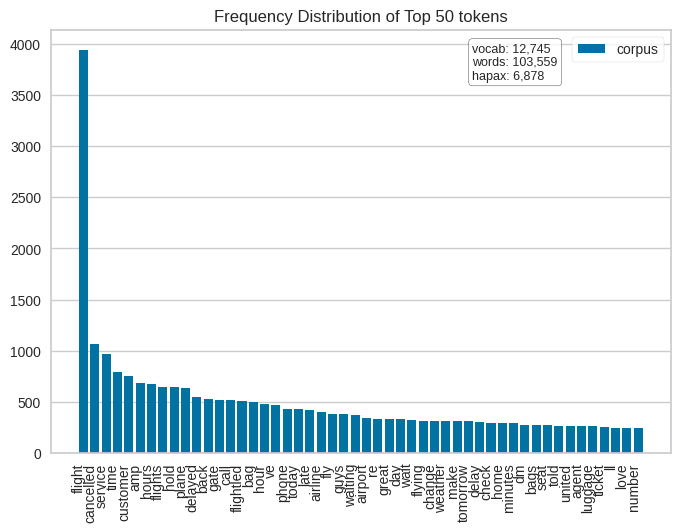

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [7]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [10]:
lengths = np.array(lengths)
X = np.array(X)

print(np.sum((lengths < 64) & (labels == "positive")), np.mean((lengths < 64) & (labels == "positive")))
print(np.sum((lengths < 64) & (labels == "neutral")), np.mean((lengths < 64) & (labels == "neutral")))
print(np.sum((lengths < 64) & (labels == "negative")), np.mean((lengths < 64) & (labels == "negative")))

2363 0.16140710382513662
3099 0.21168032786885246
9178 0.6269125683060109


In [11]:
X_positive = X[(lengths < 64) & (labels == "positive")].tolist()
X_neutral = X[(lengths < 64) & (labels == "neutral")].tolist()
X_negative = X[(lengths < 64) & (labels == "negative")].tolist()
X = X_positive[:2000] + X_negative[:2000]

y_positive = labels[(lengths < 64) & (labels == "positive")].tolist()
y_neutral = labels[(lengths < 64) & (labels == "neutral")].tolist()
y_negative = labels[(lengths < 64) & (labels == "negative")].tolist()
y = y_positive[:2000] + y_negative[:2000]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [14]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-7.5363e-02, -9.3021e-02, -1.5182e-01,  ..., -4.2234e-01,
           7.9174e-01, -1.6137e-01],
         [-2.2617e-01,  9.6144e-03, -2.6507e-02,  ..., -2.2790e-01,
           8.4660e-01, -5.1540e-02],
         [-1.3913e-01, -1.9052e-04,  7.6965e-02,  ..., -1.7846e-01,
           7.3487e-01, -9.9390e-02],
         ...,
         [-9.8426e-02, -1.5255e-01,  1.3095e-03,  ..., -5.8747e-01,
           7.9824e-01, -1.8459e-01],
         [-9.5067e-02, -1.5174e-01,  1.9620e-04,  ..., -5.7788e-01,
           8.1405e-01, -1.8456e-01],
         [-1.0115e-01, -1.1341e-01, -1.5261e-02,  ..., -5.8779e-01,
           8.0019e-01, -1.8620e-01]],

        [[-1.0978e-01, -1.9171e-01, -8.2797e-02,  ..., -3.1733e-01,
           5.8903e-01, -3.3747e-01],
         [-1.5571e-01, -8.8075e-02, -5.7721e-02,  ..., -2.2870e-01,
           7.0860e-01, -1.4940e-01],
         [-1.0070e-02, -1.2868e-01,  7.3472e-02,  ..., -2.2265e-01,
           6.

In [15]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [16]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.4106,  0.0356, -0.1524,  ..., -0.7065,  0.6060,  0.2967],
         [-0.0080,  0.3725,  0.3838,  ..., -0.9661, -0.0378,  0.3705],
         [-0.2151,  0.4282,  0.4166,  ..., -0.9473, -0.0426,  0.4057],
         ...,
         [-0.4265, -0.1275, -0.1309,  ..., -0.7103,  0.6995,  0.1659],
         [-0.4181, -0.1374, -0.1322,  ..., -0.6964,  0.7320,  0.1783],
         [-0.3852, -0.1236, -0.1441,  ..., -0.6981,  0.7159,  0.1590]],

        [[-0.2735, -0.0434,  0.0442,  ..., -0.8853,  0.6465, -0.1472],
         [-0.2435,  0.3538,  0.2268,  ..., -0.7507, -0.0549,  0.2275],
         [-0.0241,  0.5807,  0.1266,  ..., -0.7887, -0.1261, -0.1827],
         ...,
         [-0.2945, -0.2472,  0.2106,  ..., -0.9293,  0.7591, -0.2284],
         [-0.3000, -0.2333,  0.2086,  ..., -0.9302,  0.7722, -0.2228],
         [-0.2847, -0.1964,  0.1824,  ..., -0.9224,  0.7514, -0.2326]],

        [[-0.2938, -0.0050, -0.0172,  ..., -0.6718,  

In [17]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [18]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [19]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, le.transform(y_train))

MLPClassifier()

In [20]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == le.transform(y_test)))

Train accuracy: 0.884
Test accuracy: 0.74


In [21]:
print(np.unique(y_test))

['negative' 'positive']


In [22]:
np.mean(y_test=="negative")

0.3

In [23]:
shap.initjs()

In [24]:
to_explain = np.array(X_test_padded)[:20]
to_explain.shape

(20, 64)

In [25]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [27]:
permutation_values = []
permutation_explainer = shap.explainers.Permutation(prediction_model, to_explain)
for i in range(20):
  permutation_values.append(permutation_explainer(np.array([to_explain[i]])))

Permutation explainer: 2it [05:22, 322.74s/it]                                                                                        
Permutation explainer: 2it [02:41, 161.61s/it]                                                                                        
Permutation explainer: 2it [03:15, 195.50s/it]                                                                                        
Permutation explainer: 2it [05:36, 336.47s/it]                                                                                        
Permutation explainer: 2it [04:52, 292.20s/it]                                                                                        
Permutation explainer: 2it [02:39, 159.62s/it]                                                                                        
Permutation explainer: 2it [03:04, 184.85s/it]                                                                                        
Permutation explainer: 2it [05:49, 349.85s/it]         

In [28]:
perm_vals = {"values": [], "base_values": [], "data": []}
for pv in permutation_values:
    perm_vals["values"].append(pv.values[0])
    perm_vals["base_values"].append(pv.base_values[0])
    perm_vals["data"].append(pv.data[0])

Sentence: employees service kind attitude customers vital kind business . ; Prediction: [1] ; True value: negative


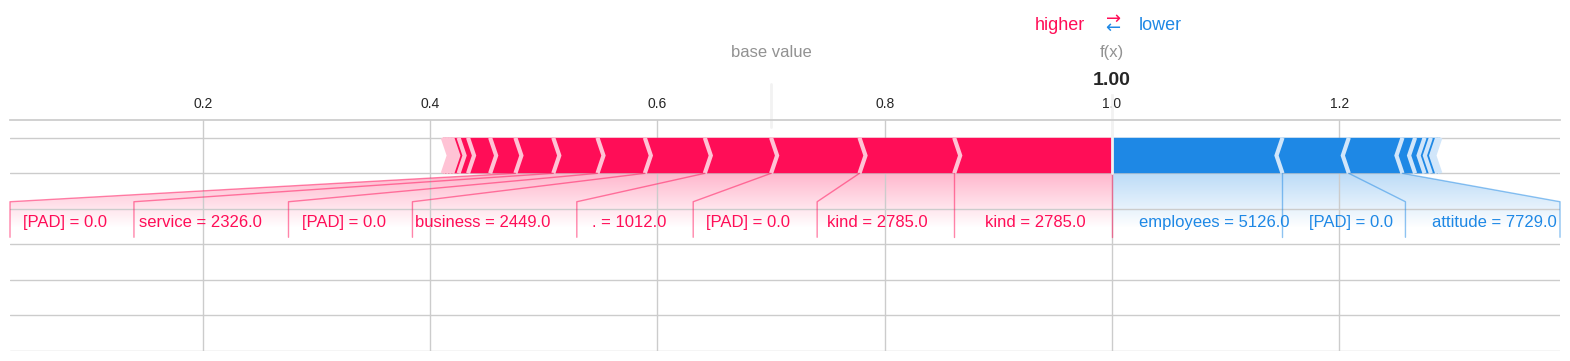

Sentence: ' s damn bag ? ? ; Prediction: [1] ; True value: negative


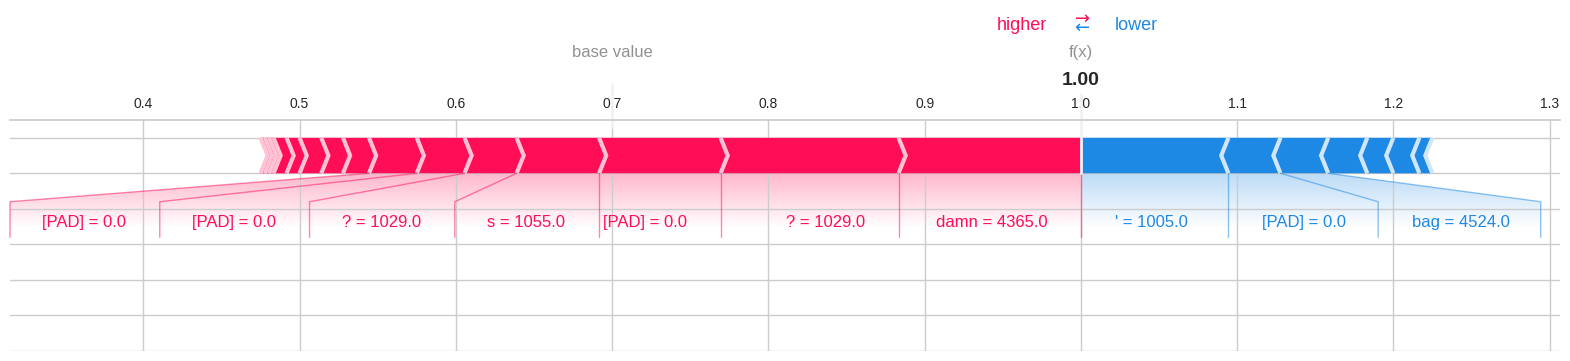

Sentence: time flying houston 45 + min ##s waiting luggage baggage . typical ? waiting . . ; Prediction: [0] ; True value: negative


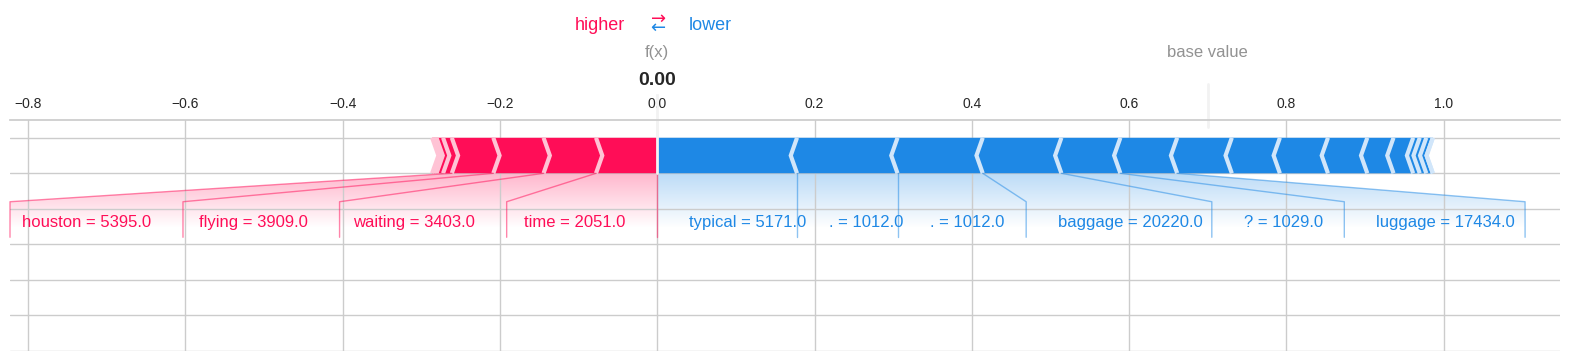

Sentence: - great flight phoenix dallas tonight ! great service time ! makes happy ! ; Prediction: [1] ; True value: positive


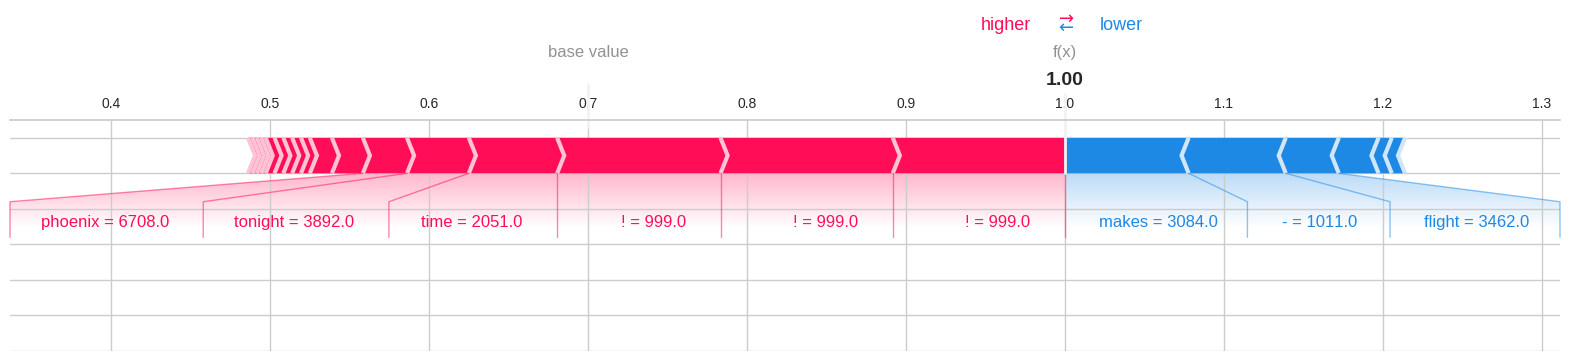

Sentence: hey awesome ! reply , filling form ! ; Prediction: [1] ; True value: positive


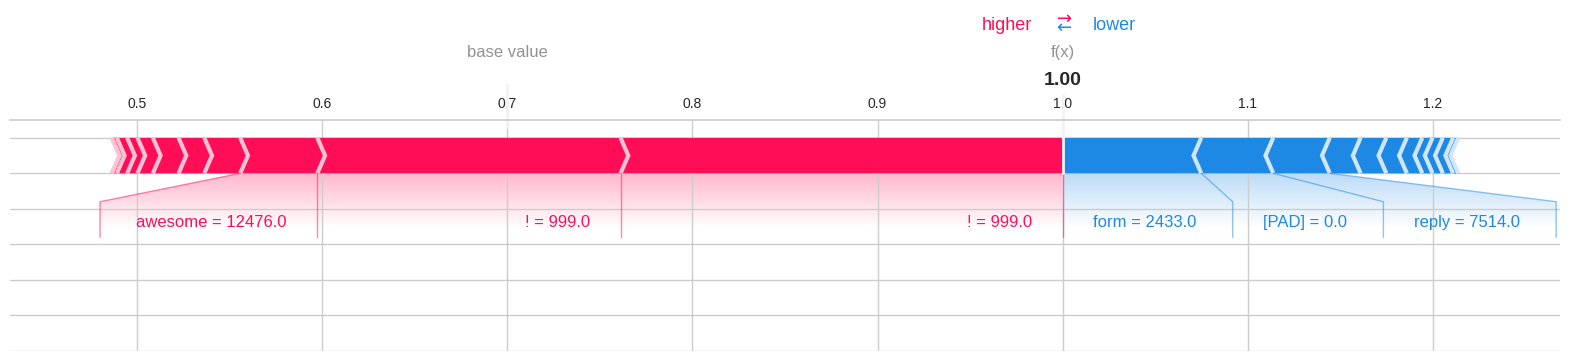

Sentence: [UNK] standing line ! ; Prediction: [1] ; True value: positive


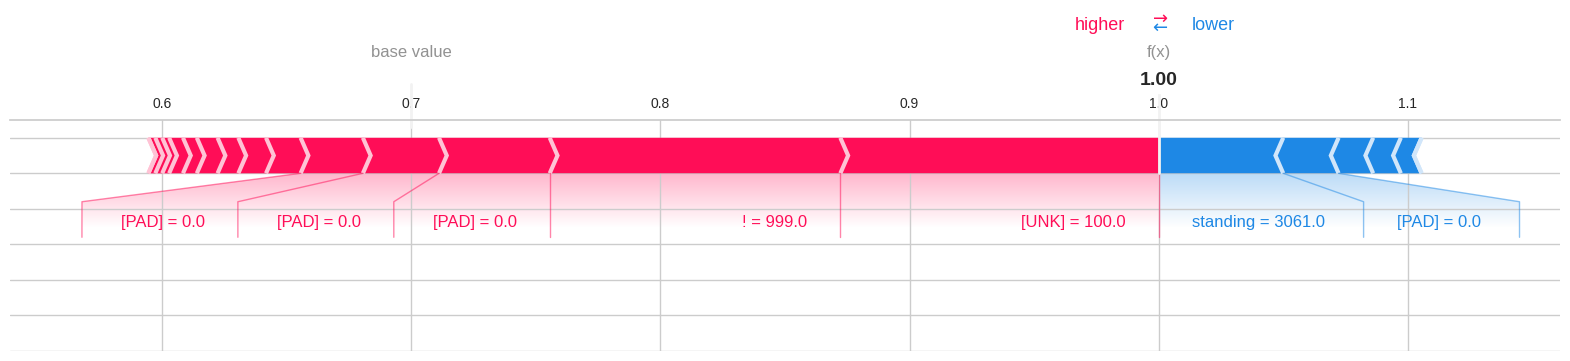

Sentence: melinda reservations greensboro nc absolute jewel ' s amazing ! ! ! ; Prediction: [1] ; True value: positive


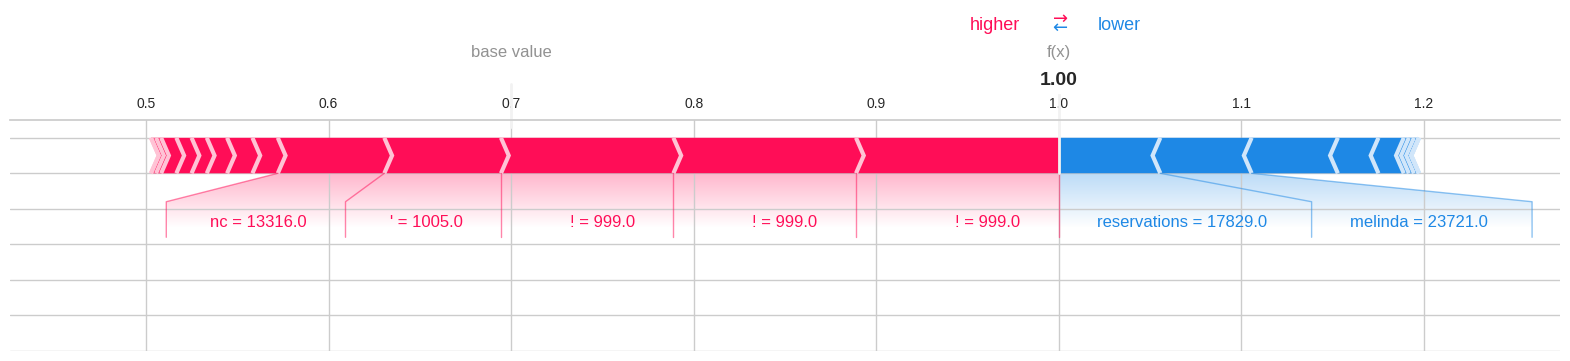

Sentence: . preferred jet blue . guys seats business . ; Prediction: [1] ; True value: positive


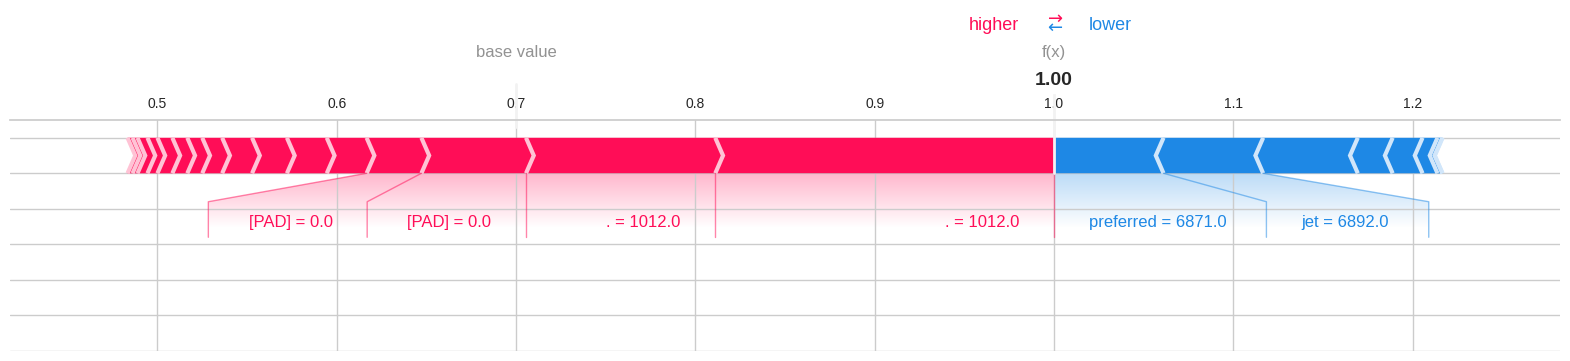

Sentence: round trip , non - english speaking friend stranded 12 + hours time ! staff members rude . ; Prediction: [1] ; True value: negative


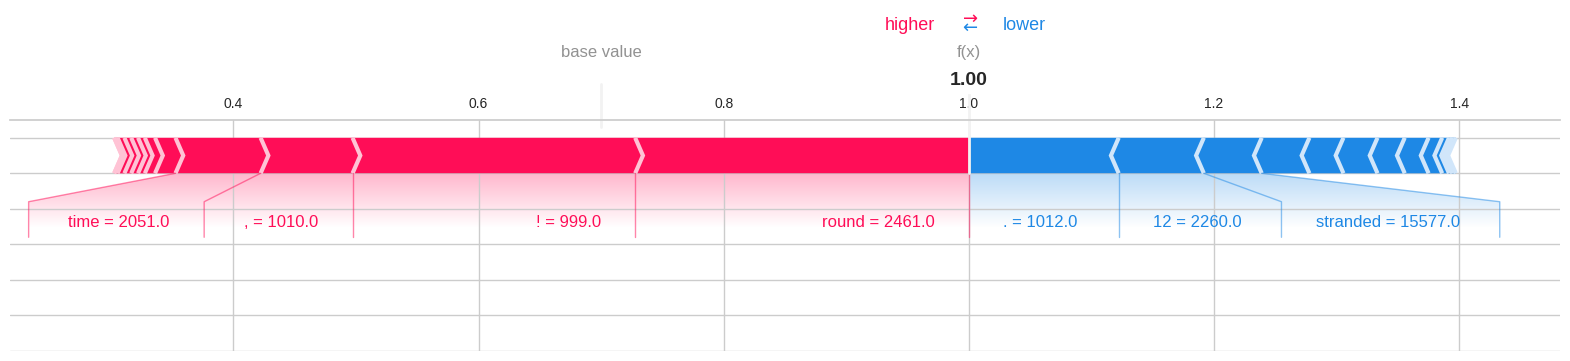

Sentence: success ! work jet ##bl ##ue team ; Prediction: [1] ; True value: positive


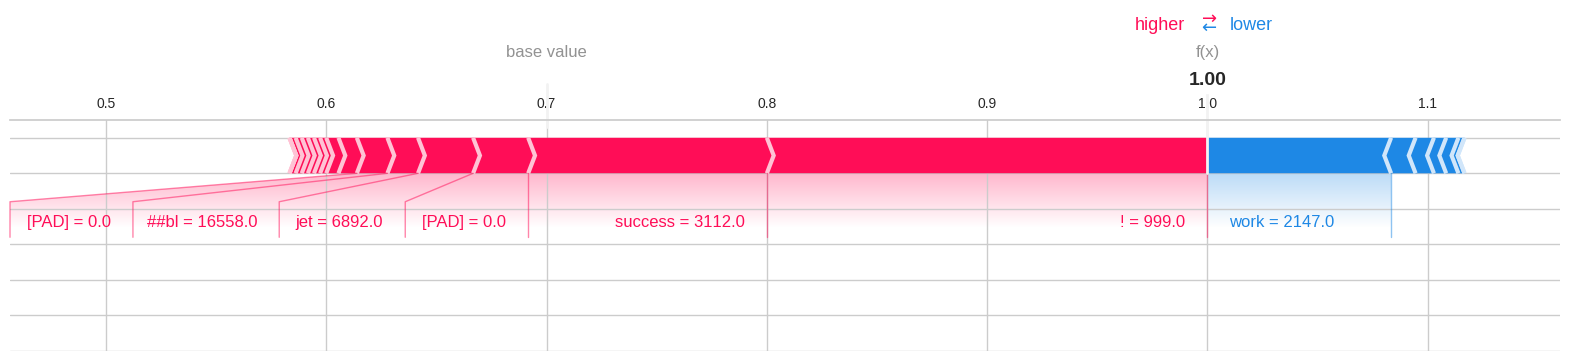

Sentence: . . . frozen lines flight , continuing due ' passenger comfort ' ? , sat plane long flight vegas ! ; Prediction: [0] ; True value: negative


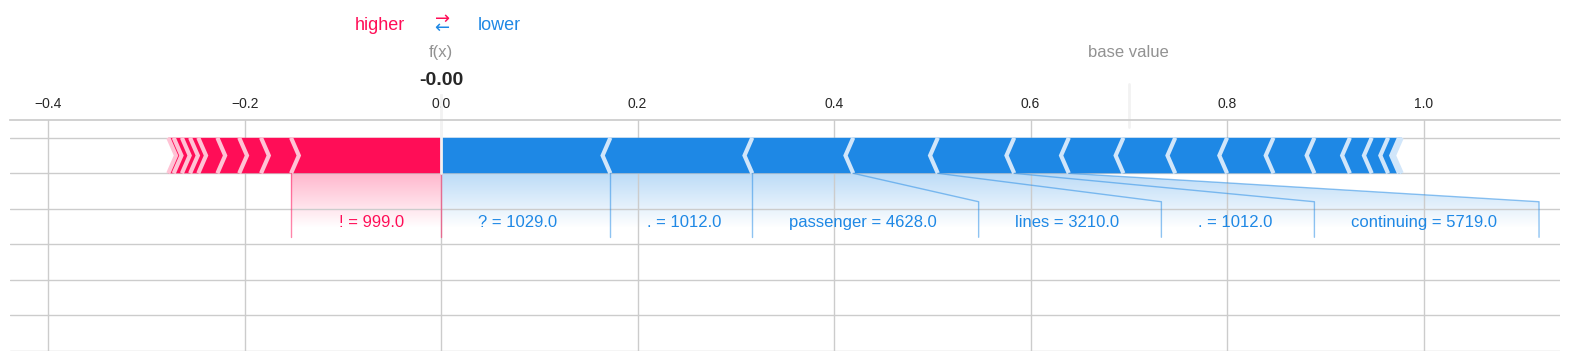

Sentence: . . . love . air travel n ' t easier . ; Prediction: [1] ; True value: positive


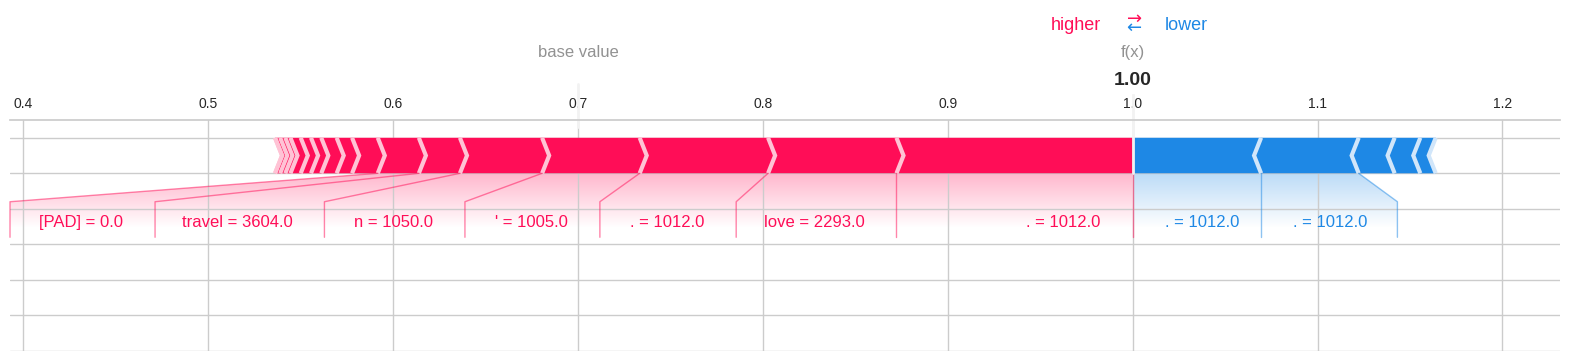

Sentence: - amazing customer service , ! [UNK] rae ##ann sf - ' s ! # customers ##er ##vic ##e # virgin ##ame ##rica # flying ; Prediction: [0] ; True value: positive


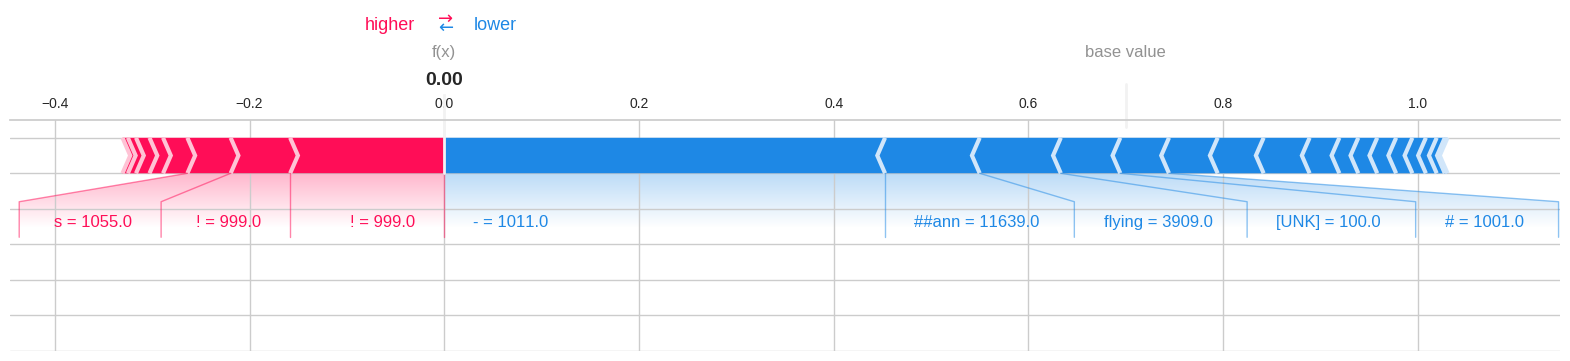

Sentence: d ##m ' d confirmation code . . . ! mommy , daddy , kids appreciate ! ; Prediction: [0] ; True value: positive


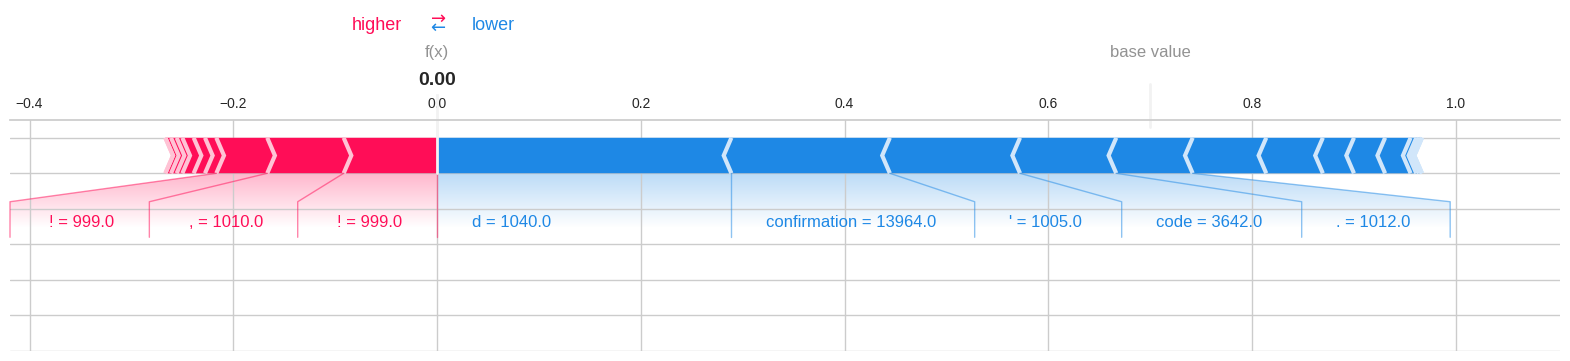

Sentence: ' s great ! . ; Prediction: [1] ; True value: positive


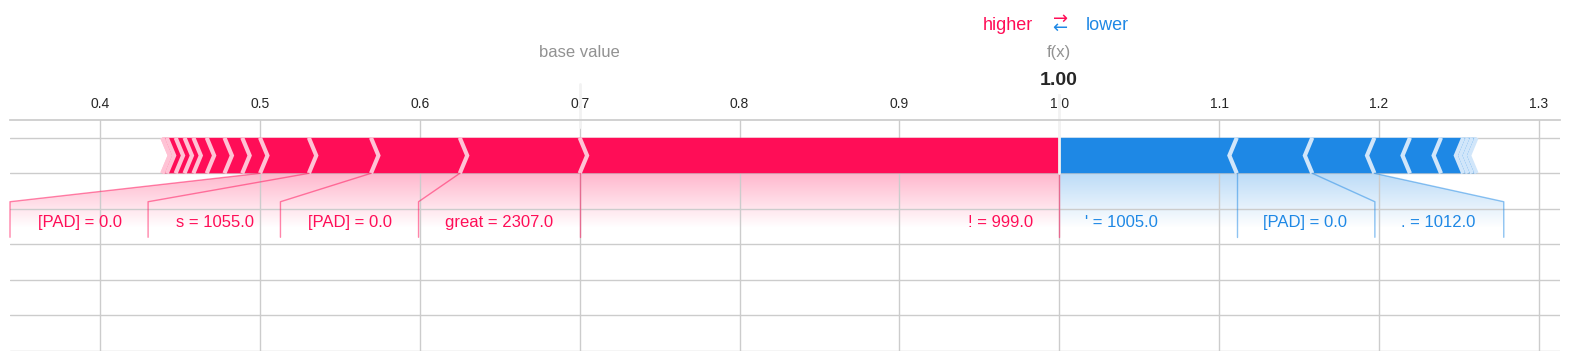

Sentence: friendly airways staff helped booked flights home today . ! ; Prediction: [1] ; True value: positive


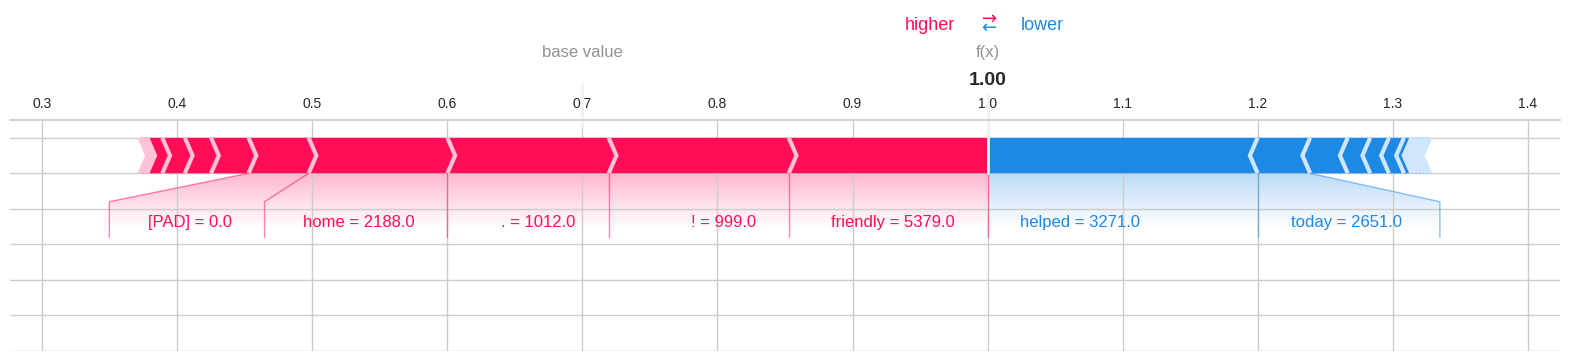

Sentence: ' s response ? shaking head back ts ##k . better - from customer service apology ; Prediction: [0] ; True value: negative


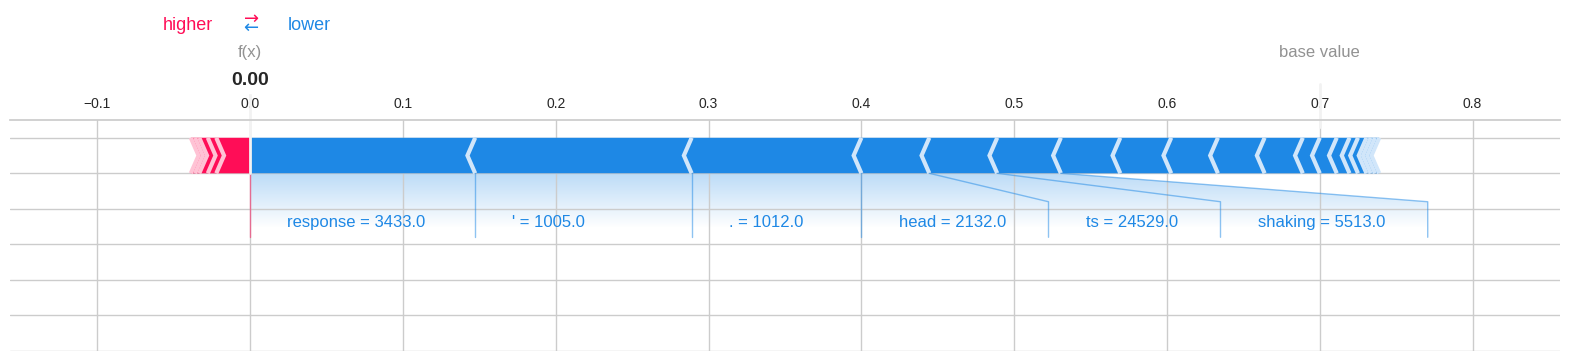

Sentence: forward beats music available flight today . ' s pretty cool . ; Prediction: [1] ; True value: positive


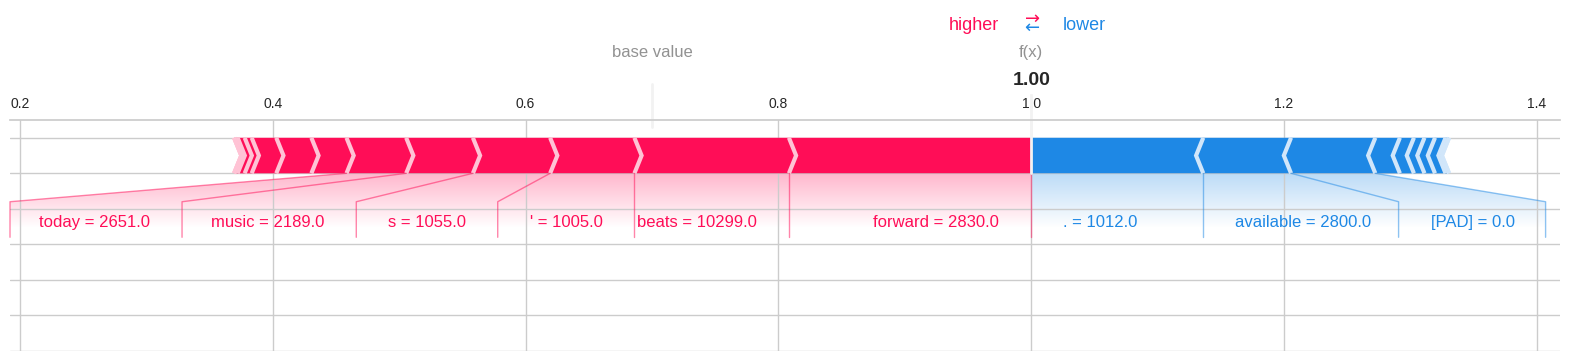

Sentence: n ' t show larry fed ##ora . : fleet ' s flee ##k . ; Prediction: [0] ; True value: positive


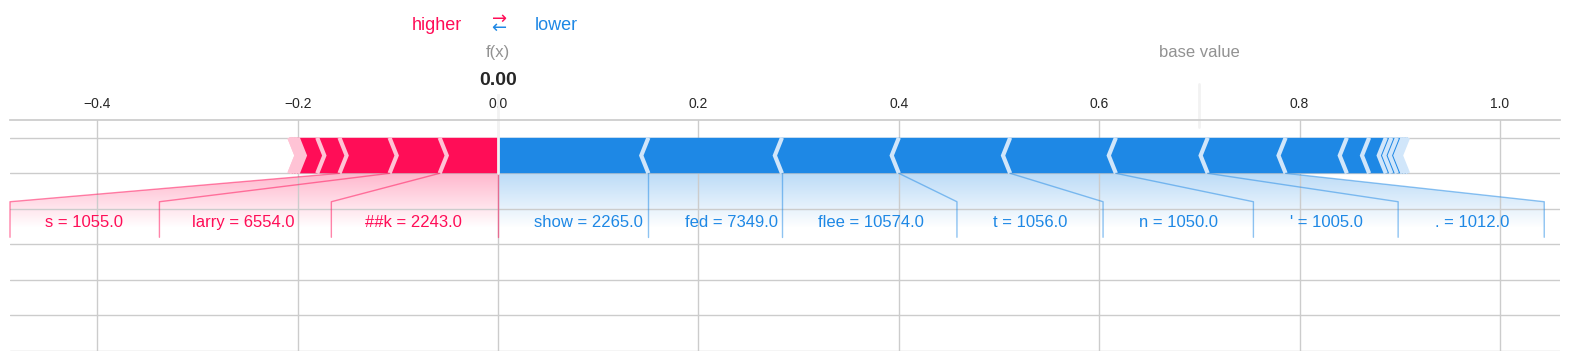

Sentence: happy finally put # southwest ##air ##lines boarding pass pass ##book ! makes life easier [UNK] ; Prediction: [1] ; True value: positive


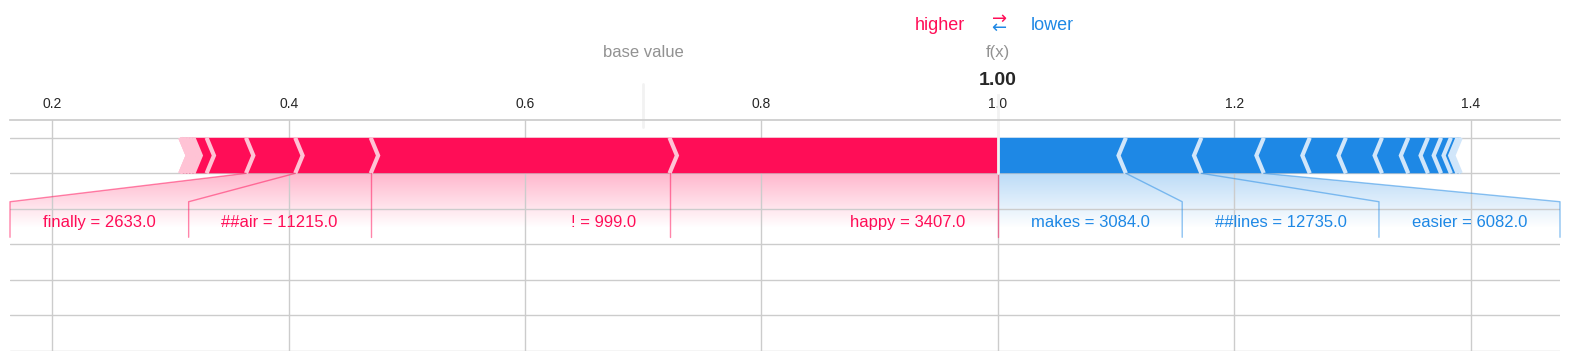

In [29]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(perm_vals["base_values"][i], perm_vals["values"][i], perm_vals["data"][i], feature_names=tokenizer.convert_ids_to_tokens(perm_vals["data"][i]), matplotlib=True)

In [30]:
import copy
heatmaps = np.array(copy.copy(perm_vals["values"]))
heatmaps += perm_vals["base_values"][0]/64
for i in range(len(heatmaps)):
  print(np.sum(heatmaps[i]))

0.9999999999999998
0.9999999999999999
-3.469446951953614e-18
0.9999999999999999
0.9999999999999998
1.0
1.0
0.9999999999999999
1.0
1.0
-8.326672684688674e-17
1.0
3.3306690738754696e-16
2.0816681711721685e-17
1.0
0.9999999999999999
0.0
0.9999999999999999
-8.326672684688674e-17
1.0


Prediction: positive


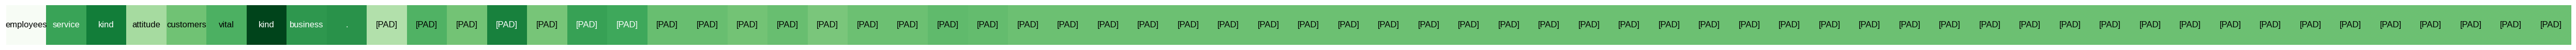

Prediction: positive


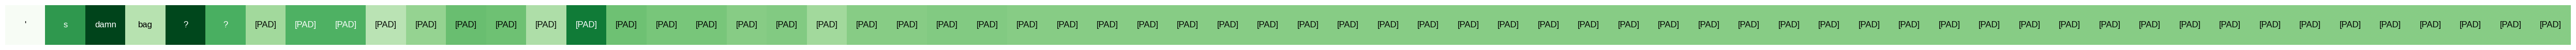

Prediction: negative


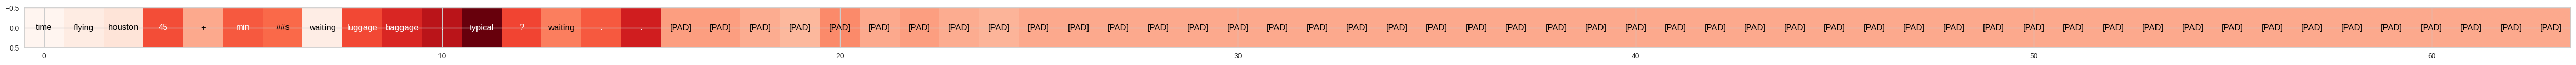

Prediction: positive


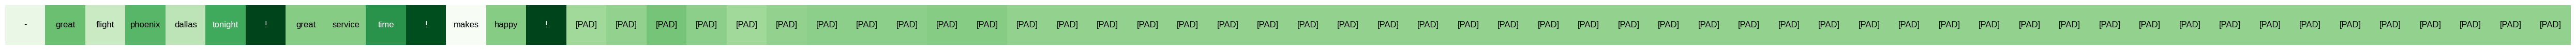

Prediction: positive


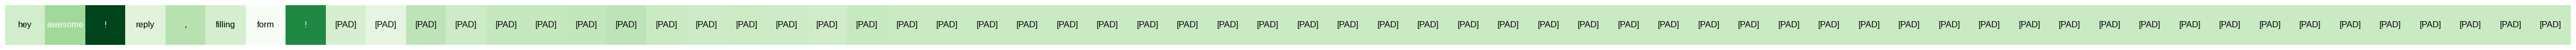

Prediction: positive


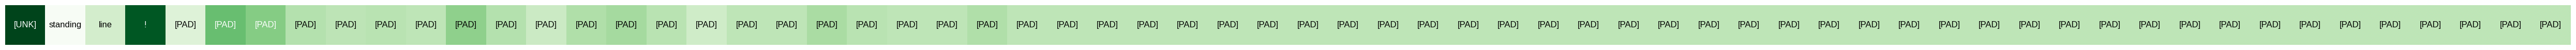

Prediction: positive


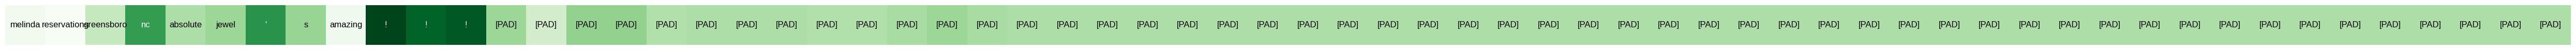

Prediction: positive


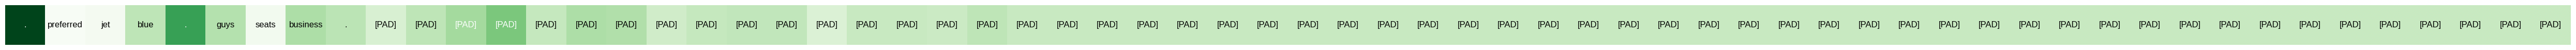

Prediction: positive


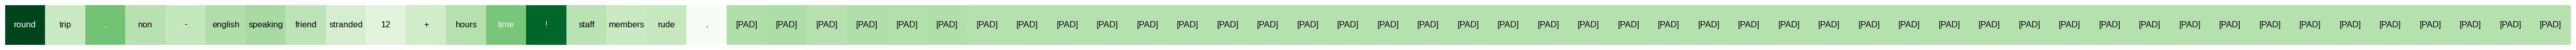

Prediction: positive


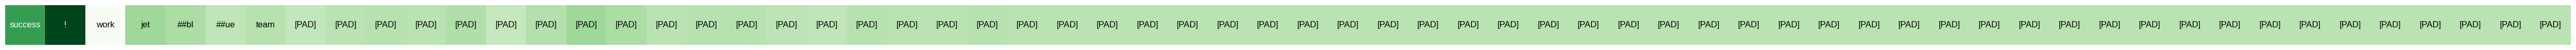

Prediction: negative


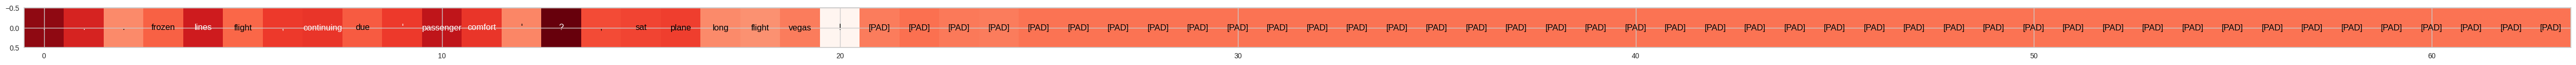

Prediction: positive


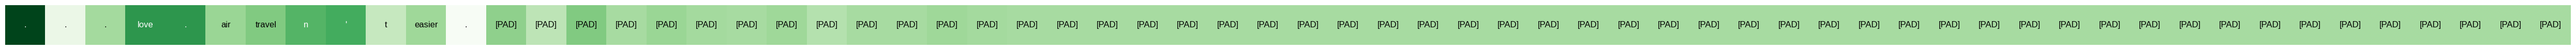

Prediction: negative


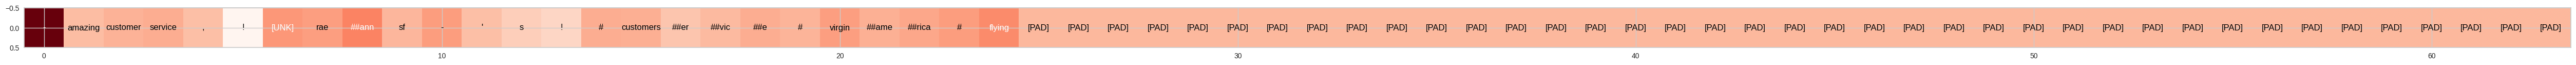

Prediction: negative


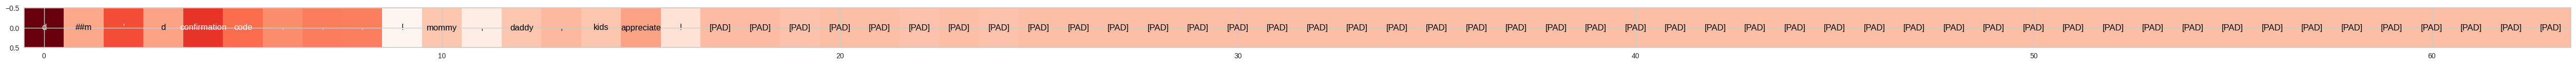

Prediction: positive


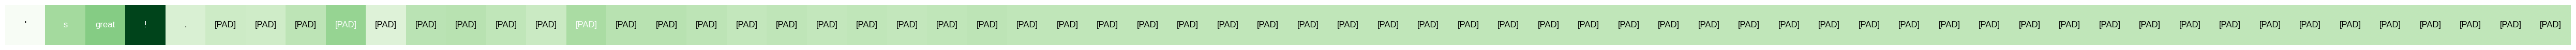

Prediction: positive


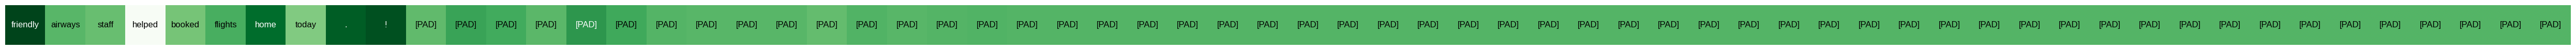

Prediction: negative


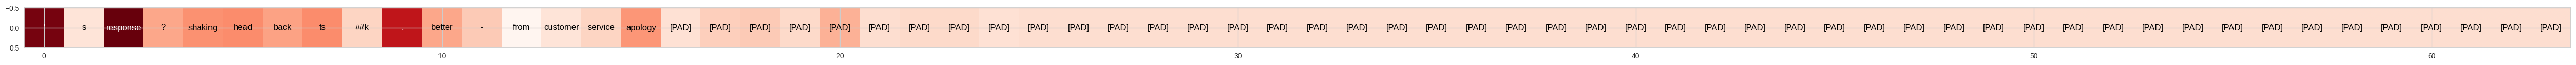

Prediction: positive


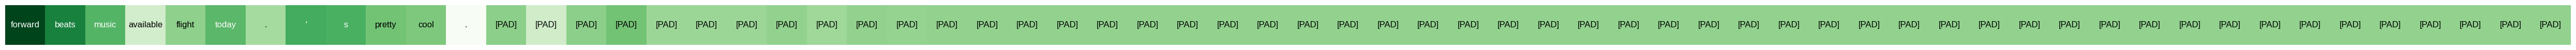

Prediction: negative


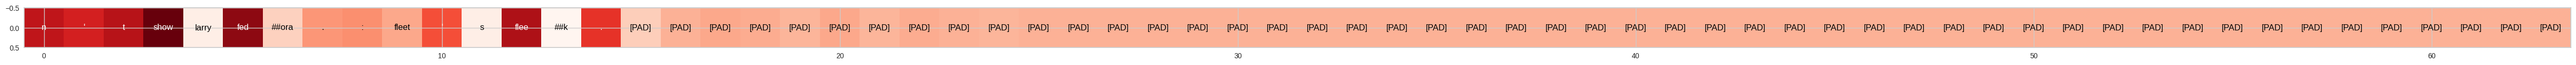

Prediction: positive


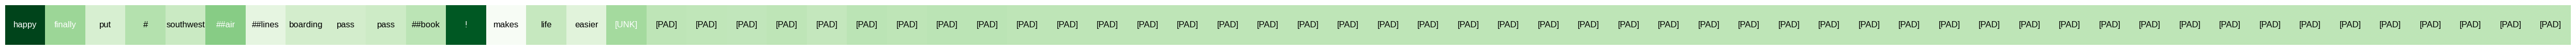

In [31]:
for x in range(len(to_explain)):
  fig, ax = plt.subplots(figsize=(len(to_explain[x]), 1))
  if prediction_model(np.array([to_explain[x]]))[0] == 0:
    print("Prediction: negative")
    ax.imshow([-heatmaps[x]], cmap="Reds", aspect="auto")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] < -0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))
  else:
    print("Prediction: positive")
    ax.imshow([heatmaps[x]], cmap="Greens", aspect="auto")
    ax.axis("off")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] > 0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))


  plt.show()

In [32]:
def ablate(x, i):
  x[i] = 0
  for j in range(i, len(x)-1):
    x[j] = x[j+1]
  x[-1] = 0
  return x
def compute_contrast(X, model, explanation):
  contrast = [0]*len(X)
  for i in range(len(X)):
    old_prediction = model(np.array([X[i]]))
    for j in range(len(X[i])):
      x = ablate(copy.deepcopy(X[i]), j)
      new_prediction = model(np.array([x]))
      if (new_prediction != old_prediction):
        contrast[i] += explanation[i][j]
  return contrast

In [33]:
def compute_distinctiveness(data, train_data, explanation):
  distinctiveness = [0] * len(data)

  frequencies = []
  for x in np.unique(train_data):
    frequencies.append((np.mean(np.array(train_data) == x), x))
  sorted_frequencies = sorted(frequencies)
  word_specialty = {0: 0}
  for i, (f, x) in enumerate(sorted_frequencies):
    word_specialty[x] = 1 - i / len(sorted_frequencies)

  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        distinctiveness[i] += word_specialty[data[i][j]] * explanation[i][j]
      except:
        distinctiveness[i] += explanation[i][j]

  return distinctiveness

In [34]:
def compute_fidelity(X, explanation, model):
    fidelity = [0] * len(X)
    samples = 5
    for i in range(len(X)):
        change_ratings = [0]*len(X[i])
        x = 0
        while x < len(X[i]):
            print(x)
            change_rating = 0
            for change in range(samples):
                new_X = copy.deepcopy(X[i])
                new_X[x] = new_X[x] + (100 * change / samples)
                if (model(np.array([X[i]])) == model(np.array([new_X]))):
                    change_rating += 1/samples
            change_ratings[x] = change_rating
            if (X[i][x] == 0):
                x = len(X[i])
            x += 1
            
        for j in range(len(X[i])):
            fidelity[i] += change_ratings[j] * explanation[i][j]
    return fidelity

In [8]:
from nltk.corpus import wordnet as wn
def compute_realism(data, id_to_token, topic, explanation, positive):
  """
  data: the word ids in the shape of #elements x #words
  topic: a wordnet synset
  id_to_token: a function from ids to tokens

  returns an array of length #elements
  """
  metrics = [0] * len(data)
  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        if (positive[i] == 1):
            metrics[i] += explanation[i][j] * topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0])
        else:
            metrics[i] += explanation[i][j] * (1 - topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0]))
      except:
        pass
  return metrics

In [36]:
for x in perm_vals["values"]:
  print(np.sum(x))

0.2999999999999999
0.30000000000000004
-0.7
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.3000000000000001
-0.7000000000000001
0.30000000000000004
-0.7
-0.7
0.3000000000000001
0.30000000000000004
-0.7
0.3000000000000002
-0.7
0.30000000000000004


In [37]:
def explanation_converter(explanations):
  new_explanations = []
  for i in range(len(explanations)):
    if (np.sum(explanations[i]) > 0):
      new_explanations.append(explanations[i] + (1 - np.sum(explanations[i]))/64)
    else:
      new_explanations.append(-explanations[i] + (1 + np.sum(explanations[i]))/64)
  return new_explanations
standardized_explanations = explanation_converter(perm_vals["values"])

In [38]:
for x in standardized_explanations:
  print(np.sum(x))
print(standardized_explanations)

1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999998
1.0000000000000002
1.0
[array([-0.1390625 ,  0.04982639,  0.09427083, -0.03628472,  0.00815972,
        0.03315972,  0.14982639,  0.06371528,  0.06927083, -0.04739583,
        0.03038194,  0.00538194,  0.08871528,  0.00260417,  0.05260417,
        0.04427083,  0.01371528,  0.01371528,  0.00538194,  0.01371528,
       -0.00017361,  0.0109375 ,  0.0109375 ,  0.01927083,  0.01649306,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0

In [39]:
contrast = compute_contrast(to_explain, prediction_model, standardized_explanations)
print(contrast)

[0.3133680555555555, 0.12760416666666669, -0.07309027777777777, 0, 0, 0, 0, 0.19982638888888887, 0, 0, 0.3289930555555555, 0, 0.5121527777777778, 0.259375, 0.3968750000000001, 0.2885416666666667, 0, 0.3623263888888889, 0, 0.26371527777777776]


In [40]:
distinctiveness = compute_distinctiveness(to_explain, X_train_padded, standardized_explanations)
print(distinctiveness)

[0.24480839558045414, 0.10529684095860548, 0.20260611188920036, 0.007341950669156535, -0.016029898070339204, -0.037423066448801647, 0.011565417833800195, -0.025243930905695516, 0.10676781823840621, 0.12129474011826928, 0.3357443394024278, 0.054235527544351146, 0.2216825202303146, 0.18347630718954275, 0.0018096405228758142, -0.006887449424214147, 0.1872058823529414, 0.17889744786803594, 0.2175076836290075, -0.05475178960473072]


In [41]:
fidelity = compute_fidelity(to_explain, standardized_explanations, prediction_model)
print(fidelity)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
[-0.053680555555555565, 0.2172222222222223, 0.7774305555555556, 0.4362847222222223, 0.4151041666666666, 0.21302083333333338, 0.438888888888889, 0.21277777777777784, 0.4883680555555555, 0.23204861111111116, 0.5595833333333335, 0.3894444444444444, 0.5145486111111112, 0.719722222222222, 0.01697916666666673, 0.043645833333333384, 0.7296875, 0.11045138888888889, 0.7225694

In [42]:
realism = compute_realism(to_explain, tokenizer.convert_ids_to_tokens, wn.synset("good.n.01"), standardized_explanations)
print(realism)

[0.06682418854293853, 0.09714832621082621, 0.04865589175485009, 0.03693224440773461, -0.01466231684981684, -0.018936965811965797, 0.008298526007625278, -0.005332219863469854, 0.047189508504612655, 0.02352659493284494, 0.10372338888858819, 0.06293567061796228, 0.025429067460317454, 0.11817197184110562, 0.02982995014245014, 0.01263113324923987, 0.09547828283735146, 0.14703525641025644, 0.1216913993606702, 0.014839436843113335]


In [43]:
predictions = prediction_model(np.array(to_explain))
print(predictions)

[1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1]


In [10]:
standardized_explanations = [np.array([-0.1390625 ,  0.04982639,  0.09427083, -0.03628472,  0.00815972,
        0.03315972,  0.14982639,  0.06371528,  0.06927083, -0.04739583,
        0.03038194,  0.00538194,  0.08871528,  0.00260417,  0.05260417,
        0.04427083,  0.01371528,  0.01371528,  0.00538194,  0.01371528,
       -0.00017361,  0.0109375 ,  0.0109375 ,  0.01927083,  0.01649306,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([-0.08350694,  0.06371528,  0.12760417, -0.01961806,  0.12482639,
        0.04427083, -0.00572917,  0.04149306,  0.04149306, -0.02239583,
        0.00260417,  0.02760417,  0.02482639, -0.0140625 ,  0.08871528,
        0.02482639,  0.01927083,  0.01927083,  0.0109375 ,  0.01371528,
       -0.00572917,  0.0109375 ,  0.0109375 ,  0.01371528,  0.01371528,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([-0.07309028, -0.05920139, -0.04809028,  0.07413194,  0.0046875 ,
        0.06579861,  0.0546875 , -0.06197917,  0.07690972,  0.1046875 ,
        0.13246528,  0.18246528,  0.0796875 ,  0.03802083,  0.06579861,
        0.11302083,  0.01302083,  0.01302083,  0.00190972, -0.00642361,
        0.0296875 ,  0.0046875 ,  0.01302083,  0.00190972, -0.00364583,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ]), np.array([-0.05017361,  0.03038194, -0.02239583,  0.03871528, -0.0140625 ,
        0.04982639,  0.11927083,  0.01649306,  0.01649306,  0.06649306,
        0.11371528, -0.06684028,  0.01649306,  0.11927083,  0.00260417,
        0.0109375 ,  0.02482639,  0.01371528,  0.00260417,  0.0109375 ,
        0.01371528,  0.01371528,  0.01371528,  0.01649306,  0.01649306,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([-1.73611111e-04,  5.26041667e-02,  2.49826389e-01, -1.96180556e-02,
        3.03819444e-02, -2.95138889e-03, -6.40625000e-02,  1.74826389e-01,
       -5.72916667e-03, -2.79513889e-02,  2.48263889e-02,  5.38194444e-03,
        1.64930556e-02,  1.64930556e-02,  1.92708333e-02,  2.48263889e-02,
        1.09375000e-02,  5.38194444e-03,  8.15972222e-03,  5.38194444e-03,
        2.60416667e-03,  1.37152778e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02]), np.array([ 0.13871528, -0.0390625 , -0.00295139,  0.12760417, -0.01128472,
        0.05538194,  0.04149306,  0.01649306,  0.0109375 ,  0.01371528,
        0.0109375 ,  0.0359375 ,  0.01649306,  0.00260417,  0.01927083,
        0.02482639,  0.01371528, -0.00017361,  0.0109375 ,  0.0109375 ,
        0.02204861,  0.01371528,  0.0109375 ,  0.0109375 ,  0.01927083,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([-0.0390625 , -0.04461806, -0.00295139,  0.06927083,  0.0109375 ,
        0.01927083,  0.07482639,  0.02204861, -0.03628472,  0.12204861,
        0.10538194,  0.1109375 ,  0.01927083, -0.01128472,  0.02482639,
        0.02482639,  0.00815972,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.00815972,  0.00815972,  0.01371528,  0.01927083,  0.01371528,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([ 0.19982639, -0.05017361, -0.04461806,  0.01927083,  0.11649306,
        0.02760417, -0.04184028,  0.03315972,  0.02204861, -0.00572917,
        0.01927083,  0.04149306,  0.06927083,  0.01371528,  0.03315972,
        0.03038194,  0.00260417,  0.01371528,  0.01649306,  0.01649306,
       -0.00850694,  0.0109375 ,  0.0109375 ,  0.00815972,  0.01927083,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([ 2.83159722e-01, -1.68402778e-02,  8.59375000e-02,  8.15972222e-03,
       -8.50694444e-03,  1.64930556e-02,  2.76041667e-02, -1.73611111e-04,
       -3.62847222e-02, -5.85069444e-02, -2.79513889e-02,  1.09375000e-02,
        8.03819444e-02,  2.41493056e-01,  5.38194444e-03, -1.68402778e-02,
       -1.12847222e-02, -1.11284722e-01,  1.64930556e-02,  1.92708333e-02,
        8.15972222e-03,  1.64930556e-02,  1.37152778e-02,  1.64930556e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02]), np.array([ 1.19270833e-01,  2.10937500e-01, -7.23958333e-02,  3.59375000e-02,
        2.48263889e-02,  5.38194444e-03,  1.37152778e-02,  2.60416667e-03,
        1.09375000e-02,  1.37152778e-02,  1.09375000e-02,  1.92708333e-02,
       -1.73611111e-04,  1.64930556e-02,  3.59375000e-02,  2.48263889e-02,
        1.09375000e-02,  1.37152778e-02,  1.37152778e-02,  8.15972222e-03,
        5.38194444e-03,  1.37152778e-02,  1.09375000e-02,  1.09375000e-02,
        1.37152778e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02]), np.array([ 0.14913194,  0.08246528, -0.01753472,  0.02135417,  0.09079861,
        0.01579861,  0.05746528,  0.06024306,  0.02690972,  0.05746528,
        0.10746528,  0.06024306, -0.01475694,  0.17690972,  0.04079861,
        0.04635417,  0.05190972, -0.01753472, -0.02586806, -0.00364583,
       -0.14809028, -0.00364583,  0.00746528, -0.00086806, -0.00364583,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ]), np.array([ 0.13871528, -0.04184028,  0.01371528,  0.08038194,  0.08038194,
        0.01927083,  0.03315972,  0.05538194,  0.06371528, -0.00850694,
        0.01649306, -0.05850694,  0.02482639, -0.00295139,  0.03315972,
        0.0109375 ,  0.01927083,  0.01371528,  0.0109375 ,  0.01649306,
        0.00260417,  0.0109375 ,  0.0109375 ,  0.01649306,  0.01371528,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([ 0.45746528, -0.00364583,  0.01579861,  0.02413194, -0.00920139,
       -0.15364583,  0.06579861,  0.05190972,  0.10190972,  0.00746528,
        0.0546875 , -0.00920139, -0.03975694, -0.05642361,  0.02413194,
        0.02135417, -0.0203125 , -0.00086806,  0.02413194,  0.01302083,
        0.05190972,  0.01857639,  0.03524306,  0.0546875 ,  0.08802083,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ]), np.array([ 0.29357639,  0.0296875 ,  0.13246528,  0.03524306,  0.16024306,
        0.09913194,  0.06024306,  0.0796875 ,  0.07690972, -0.08697917,
       -0.00642361, -0.0703125 , -0.00642361,  0.01024306, -0.00642361,
        0.03524306, -0.0453125 ,  0.00746528,  0.00746528, -0.00086806,
        0.0046875 ,  0.0046875 , -0.00086806,  0.0046875 , -0.00086806,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ]), np.array([-0.10017361,  0.04982639,  0.0859375 ,  0.3109375 , -0.02795139,
       -0.00850694, -0.01128472,  0.01649306,  0.06649306, -0.03628472,
        0.01927083,  0.02204861,  0.0109375 , -0.00295139,  0.04149306,
        0.02204861,  0.02204861,  0.01649306,  0.00815972,  0.01371528,
        0.00815972,  0.0109375 ,  0.00815972,  0.0109375 ,  0.01649306,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ,
        0.0109375 ,  0.0109375 ,  0.0109375 ,  0.0109375 ]), np.array([ 1.58159722e-01,  8.15972222e-03, -5.72916667e-03, -1.89062500e-01,
       -1.68402778e-02,  2.20486111e-02,  1.13715278e-01, -2.79513889e-02,
        1.30381944e-01,  1.44270833e-01, -1.73611111e-04,  3.87152778e-02,
        2.76041667e-02,  5.38194444e-03,  5.53819444e-02,  3.03819444e-02,
        1.09375000e-02,  8.15972222e-03,  8.15972222e-03,  8.15972222e-03,
       -2.95138889e-03,  1.37152778e-02,  8.15972222e-03,  1.09375000e-02,
        1.37152778e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02]), np.array([ 0.14635417, -0.00086806,  0.15190972,  0.03524306,  0.04635417,
        0.04913194,  0.03802083,  0.04913194,  0.01024306,  0.11579861,
        0.03524306,  0.01579861, -0.01753472, -0.00086806,  0.01024306,
        0.04357639,  0.00190972,  0.01302083,  0.01579861,  0.00746528,
        0.0296875 ,  0.0046875 ,  0.00746528,  0.00746528,  0.00190972,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ]), np.array([ 2.02604167e-01,  1.33159722e-01,  6.37152778e-02, -5.85069444e-02,
        1.37152778e-02,  5.81597222e-02, -8.50694444e-03,  7.76041667e-02,
        7.20486111e-02,  3.87152778e-02,  3.03819444e-02, -1.25173611e-01,
        1.64930556e-02, -5.57291667e-02,  1.64930556e-02,  3.87152778e-02,
        2.60416667e-03,  2.60416667e-03,  2.60416667e-03,  1.09375000e-02,
       -1.73611111e-04,  1.09375000e-02,  8.15972222e-03,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02]), np.array([ 0.11024306,  0.09635417,  0.11579861,  0.1546875 , -0.0453125 ,
        0.13802083, -0.01753472,  0.02135417,  0.02690972,  0.01024306,
        0.06579861, -0.0453125 ,  0.12135417, -0.05364583,  0.08246528,
       -0.01475694,  0.0046875 ,  0.01024306,  0.00746528,  0.00190972,
        0.01024306,  0.00190972,  0.00746528,  0.0046875 ,  0.00190972,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ,
        0.0046875 ,  0.0046875 ,  0.0046875 ,  0.0046875 ]), np.array([ 2.88715278e-01,  5.26041667e-02, -2.79513889e-02,  2.20486111e-02,
       -5.72916667e-03,  7.48263889e-02, -5.29513889e-02, -1.96180556e-02,
       -1.96180556e-02, -1.12847222e-02,  1.37152778e-02,  2.63715278e-01,
       -9.73958333e-02, -1.73611111e-04, -4.18402778e-02,  4.42708333e-02,
        1.09375000e-02,  8.15972222e-03,  5.38194444e-03,  1.09375000e-02,
        2.60416667e-03,  1.37152778e-02,  1.09375000e-02,  1.37152778e-02,
        1.37152778e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02,
        1.09375000e-02,  1.09375000e-02,  1.09375000e-02,  1.09375000e-02])]

In [5]:
to_explain = [['employees', 'service', 'kind', 'attitude', 'customers', 'vital', 'kind', 'business', '.'],
['\'', 's', 'damn', 'bag', '?', '?'],
['time', 'flying', 'houston', '45', '+', 'min', '##s', 'waiting', 'luggage', 'baggage', '.', 'typical', '?', 'waiting', '.', '.'],
['-', 'great', 'flight', 'phoenix', 'dallas', 'tonight', '!', 'great', 'service', 'time', '!', 'makes', 'happy', '!'],
['hey', 'awesome', '!', 'reply', ',', 'filling', 'form', '!'],
['[UNK]', 'standing', 'line', '!'],
['melinda', 'reservations', 'greensboro', 'nc', 'absolute', 'jewel', '\'', 's', 'amazing', '!', '!', '!'],
['.', 'preferred', 'jet', 'blue', '.', 'guys', 'seats', 'business', '.'],
['round', 'trip', ',', 'non', '-', 'english', 'speaking', 'friend', 'stranded', '12', '+', 'hours', 'time', '!', 'staff', 'members', 'rude', '.'],
['success', '!', 'work', 'jet', '##bl', '##ue', 'team'],
['.', '.', '.', 'frozen', 'lines', 'flight', ',', 'continuing', 'due', '\'', 'passenger', 'comfort', '\'', '?', ',', 'sat', 'plane', 'long', 'flight', 'vegas', '!'],
['.', '.', '.', 'love', '.', 'air', 'travel', 'n', '\'', 't', 'easier', '.'],
['-', 'amazing', 'customer', 'service', ',', '!', '[UNK]', 'rae', '##ann', 'sf', '-', '\'', 's', '!', '#', 'customers', '##er', '##vic', '##e', '#', 'virgin', '##ame', '##rica', '#', 'flying'],
['d', '##m', '\'', 'd', 'confirmation', 'code', '.', '.', '.', '!', 'mommy', ',', 'daddy', ',', 'kids', 'appreciate', '!'],
['\'', 's', 'great', '!', '.'],
['friendly', 'airways', 'staff', 'helped', 'booked', 'flights', 'home', 'today', '.', '!'],
['\'', 's', 'response', '?', 'shaking', 'head', 'back', 'ts', '##k', '.', 'better', '-', 'from', 'customer', 'service', 'apology'],
['forward', 'beats', 'music', 'available', 'flight', 'today', '.', '\'', 's', 'pretty', 'cool', '.'],
['n', '\'', 't', 'show', 'larry', 'fed', '##ora', '.', ':', 'fleet', '\'', 's', 'flee', '##k', '.'],
['happy', 'finally', 'put', '#', 'southwest', '##air', '##lines', 'boarding', 'pass', 'pass', '##book', '!', 'makes', 'life', 'easier', '[UNK]']]
for i in range(len(to_explain)):
    to_explain[i] = tokenizer.convert_tokens_to_ids(to_explain[i])
    to_explain[i] += [0] * (64 - len(to_explain[i]))

In [6]:
prediction = [1,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,0,1,0]

In [12]:
realism = compute_realism(to_explain, tokenizer.convert_ids_to_tokens, wn.synset("good.n.01"), standardized_explanations, prediction)
print(realism)

[0.0668241888974359, 0.09714832841025639, 0.25099687242063495, 0.03693224901414925, -0.014662316857142855, -0.018936966153846154, 0.008298524475490197, -0.005332222281718285, 0.04718950849569536, 0.023526594846153846, 0.33030439843036585, 0.06293566825152624, 0.13238343245299145, 0.4859947068750562, 0.029829950512820513, 0.01263113320457875, 0.3263967067099045, 0.14703525639128207, 0.48334332799603175, 0]
